Assumed a Marketing Campaign that shows people two version of an online shopping page:

<img src="Bayesian Interference/Example.png" width="500">

As depicted in the picture above, there are two versions of the website, namely, A and B with two different colour of Buy-button.

The question here: __what is the probability that the next customer will click "Buy" for each version?__

Assumed that A has been shown to 20 customers and 12 of them clicked buy: denoted as $N_{A} = 20$ and $C_{A} = 12$
and B has been shown to 15 customers and 11 of them clicked buy: denoted as $N_{B} = 15$ and $C_{B} = 11$.

From the assumption of $N_{A} = 20$, $C_{A} = 12$, $N_{B} = 15$ and $C_{B} = 11$ above we can immediately (MLE) tell the Maximum Likelihood Estimation for each case is $mle_{A} = 12/20 = 0.6$ and $mle_{B} = 11/15 = 0.73$

However, lets assume that we have historical records of 100 campaigns in the pass. This historical records, for the sake of simplicity, contains only the number of testing customers and number of clicks for each campaigns. Now we take into account the information we had in the past based on the records, and the new observation, to find out the probability that the next customer will click buy-button using Bayesian Interference method.

Bayesian Interference generally invoved the following steps:

1. Define a belief about the data, namely, prior probability $P(data)$.
2. Define the relationtion ship between data and the current event/fact/observation denoted as $\theta$, namely, likelihood probalilty $P(\theta|data)$.
3. Find out how the original belief changed according to the current event/fact/observation, namely, posterior probability $P(data|\theta)$.

This historical records is usally modelled with beta distribution, therefore, I will generate the data for this records based on beta distribution and used as our prior belief or prior probability. 

The act of finding how many customers will click onto the buy-button out of a certain amount of testing customers can be modelled with binomial distribution. This is treated as our likelihood probability.

Bayes's theorem: $P(data|\theta) = \displaystyle \frac{P(\theta|data)P(data)}{P(\theta)}$. $P(\theta)$ is usually complicated to compute and acts as a normlised factor only, so it is neglectable. 

Lets first generate data for historical records.

In [2]:
#!/usr/bin/env py27
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import beta

plt.rcParams['figure.figsize'] = (16, 9)
np.random.seed(111)

n_campaigns = 100 # historical records of 100 campaigns
max_customers = 5000

# assumed the historical record followed the following beta distribution:
beta_a = 10
beta_b = 20
true_prior = np.random.beta(beta_a, beta_b, size = n_campaigns)
customers = np.random.randint(1, max_customers, size = n_campaigns)

# Since we actually dont know the click-buy event will follow beta distribution
# all I have in the records were just number of clicks and total number of testing customers for each campaign
# draw samples or generate "number of clicks" for each campaign
clicks = np.random.binomial(customers, true_prior).astype(float)
click_rates = clicks/customers

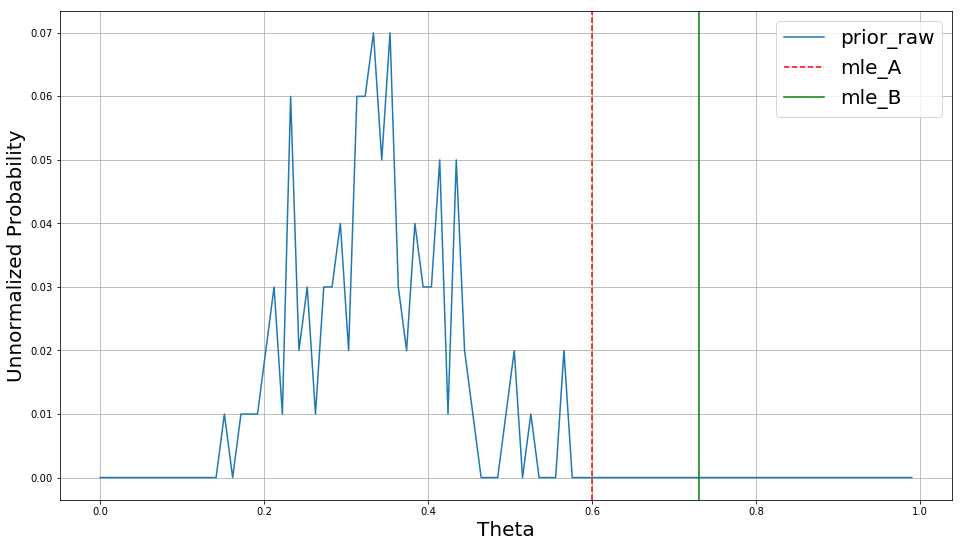

In [3]:
# Plot raw data and mle together
mle_a = 0.6
mle_b = 0.73
bins = np.linspace(0, 1, 100)
prior_count, _ = np.histogram(click_rates, bins)
prior_count = map(lambda x: float(x)/prior_count.sum(), prior_count)
plt.plot(bins[:-1], prior_count, label='prior_raw')
plt.axvline(mle_a, color='r', linestyle = "--", label='mle_A')
plt.axvline(mle_b, color='g', label='mle_B')
plt.grid()
plt.legend(loc='upper right', prop={'size': 20})
plt.xlabel('Theta', fontsize=20)
plt.ylabel('Unnormalized Probability', fontsize=20)
plt.show()

From the above graph, it is straghtforward to see the new observation in both A and B case different from our "belief" pretty much. The prior probability is centered at 0.3 while the likeliehood for A and B are centered at 0.6 and 0.73 respectively. That is why we need to "update" our belief based on this observation.

In [4]:
# As said before, the beta distribution is in fact unknown to me, all I have is the figure above
# now I try to fit the raw data to a distribution of choice. 
# choosing the distribution here requires some effort, but for this problem, since I "cheated" and generated
# data based on beta distribution, I will just simply pick beta distribution as my fitting function.
prior_parameters = beta.fit(click_rates, floc = 0, fscale = 1) # extract a,b from fit
prior_a, prior_b = prior_parameters[0:2]
print(prior_a, prior_b)

(10.1405360583961, 19.563907347304763)


As can be seen here, the fitting function estimated alpha and beta mostly the same of the true value.

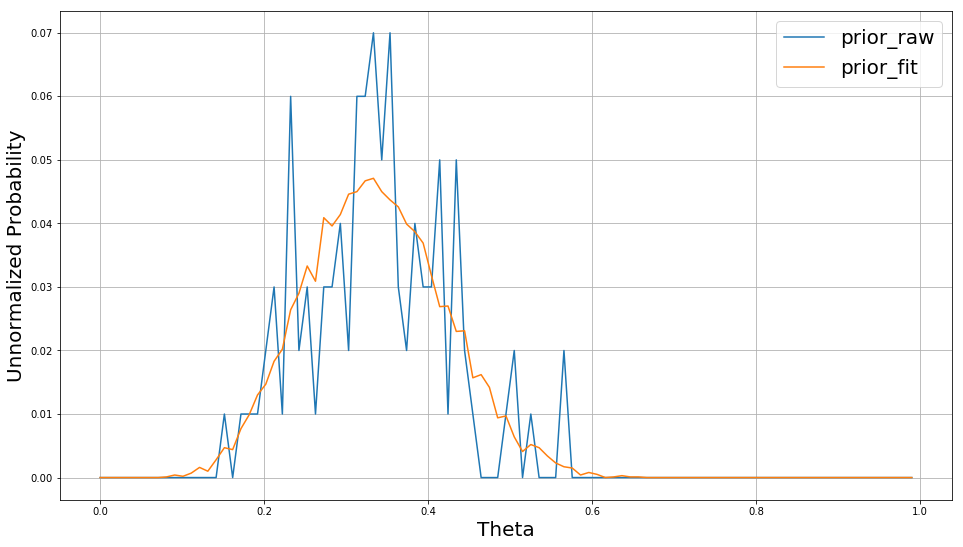

In [5]:
# Plot raw data and fit function together
prior_count, _ = np.histogram(click_rates, bins)
prior_count = map(lambda x: float(x)/prior_count.sum(), prior_count)
fitprior_count, _ = np.histogram(beta(prior_a, prior_b).rvs(10000), bins)
fitprior_count = map(lambda x: float(x)/fitprior_count.sum(), fitprior_count)
plt.plot(bins[:-1], prior_count, label='prior_raw')
plt.plot(bins[:-1], fitprior_count, label='prior_fit')
plt.grid()
plt.legend(loc='upper right', prop={'size': 20})
plt.xlabel('Theta', fontsize=20)
plt.ylabel('Unnormalized Probability', fontsize=20)
plt.show()

Now we need to find out how the observation affect the prior probability, i.e. generating posterior probability.

In [6]:
# case A: 𝑁 = 20, 𝐶 = 12
with pm.Model() as model:
    theta_prior = pm.Beta('prior', prior_a, prior_b) # prior distribution
    observations = pm.Binomial('obs', n=20, p=theta_prior, observed=12) # likelihood distribution 
    trace_a = pm.sample(5000, tuning=500, cores=1, progressbar=True, nuts_kwargs=dict(target_accept=0.95))
    
# case B: 𝑁 = 15, 𝐶 = 11
with pm.Model() as model:
    theta_prior = pm.Beta('prior', prior_a, prior_b) # prior distribution
    observations = pm.Binomial('obs', n=15, p=theta_prior, observed=11) # likelihood distribution 
    trace_b = pm.sample(5000, tuning=500, cores=1, progressbar=True, nuts_kwargs=dict(target_accept=0.95)) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [prior]
100%|████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:04<00:00, 1209.06it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [prior]
100%|████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:04<00:00, 1280.26it/s]


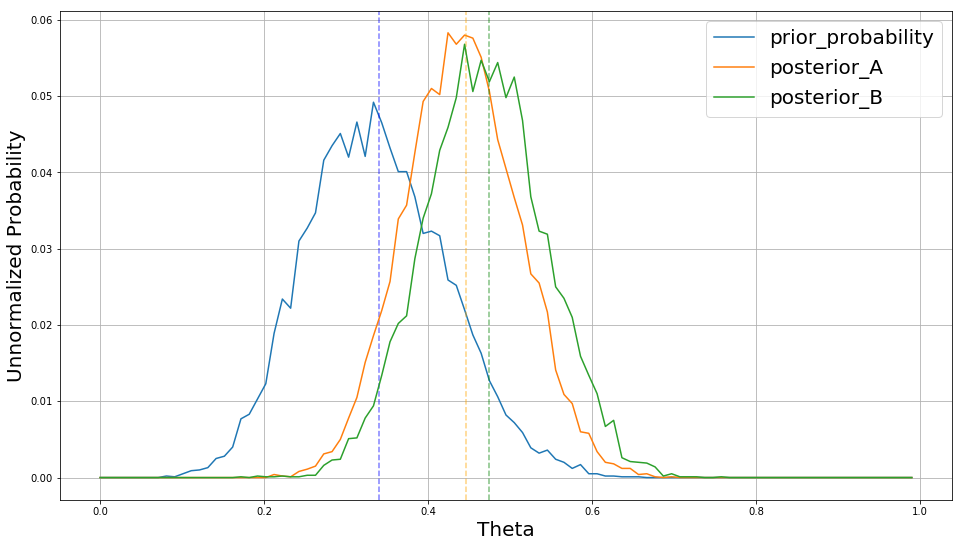

In [7]:
# plot prior vs posterior
fitprior_count, _ = np.histogram(beta(prior_a, prior_b).rvs(10000), bins)
fitprior_count = map(lambda x: float(x)/fitprior_count.sum(), fitprior_count)
posteriora_counts, _ = np.histogram(trace_a['prior'], bins)
posteriora_counts = map(lambda x: float(x)/posteriora_counts.sum(), posteriora_counts)
posteriorb_counts, _ = np.histogram(trace_b['prior'], bins)
posteriorb_counts = map(lambda x: float(x)/posteriorb_counts.sum(), posteriorb_counts)

mean_prior = np.mean(beta(prior_a, prior_b).rvs(10000))
mean_a = np.mean(trace_a['prior'])
mean_b = np.mean(trace_b['prior'])
                     
plt.plot(bins[:-1], fitprior_count, label='prior_probability')
plt.axvline(mean_prior, color='b', linestyle="--", alpha=0.5)
plt.plot(bins[:-1], posteriora_counts, label='posterior_A')
plt.axvline(mean_a, color='orange', linestyle="--", alpha=0.5)
plt.plot(bins[:-1], posteriorb_counts, label='posterior_B')
plt.axvline(mean_b, color='g', linestyle="--", alpha=0.5)
plt.grid()
plt.legend(loc='upper right', prop={'size': 20})
plt.xlabel('Theta', fontsize=20)
plt.ylabel('Unnormalized Probability', fontsize=20)
plt.show()

So we see how the prior probability is changed after the observation given for each case A and B. The most plausible theta or the most proability that the next user will click onto the buy-button for both case a and b are pretty close:

In [8]:
print('the most plausible probability: \nprior_raw {:2.2%}, \nposterior_a: {:2.2%}, \nposterior_b: {:2.2%}'\
      .format(mean_prior, mean_a, mean_b))

the most plausible probability: 
prior_raw 34.01%, 
posterior_a: 44.64%, 
posterior_b: 47.38%


In this case we can conclude that, we can go with A or B version of the website, and the results are not so much different. 
But we only test with 20 and 15 customers for case A and B, if you noticed the max_customer we set at the begining of the code, it was 5000 meaning the previous 100 campaigns were test with signigficantly more customers. Lets increase our testing customer for case A and B to 5000 however maintaining there MLE, i.e. keeping the observing rate unchange. We want to see how the observation change our belief if the sample size increases.

In [9]:
# case A: 𝑁 = 5000, 𝐶 = 0.6*5000 = 3000
with pm.Model() as model:
    theta_prior = pm.Beta('prior', prior_a, prior_b) # prior distribution
    observations = pm.Binomial('obs', n=5000, p=theta_prior, observed=3000) # likelihood distribution 
    trace_a = pm.sample(5000, tuning=500, cores=1, progressbar=True, nuts_kwargs=dict(target_accept=0.95))
    
# case B: 𝑁 = 5000, 𝐶 = 0.73*5000 = 3650
with pm.Model() as model:
    theta_prior = pm.Beta('prior', prior_a, prior_b) # prior distribution
    observations = pm.Binomial('obs', n=5000, p=theta_prior, observed=3650) # likelihood distribution 
    trace_b = pm.sample(5000, tuning=500, cores=1, progressbar=True, nuts_kwargs=dict(target_accept=0.95)) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [prior]
100%|████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:04<00:00, 1250.85it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [prior]
100%|████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:04<00:00, 1222.22it/s]


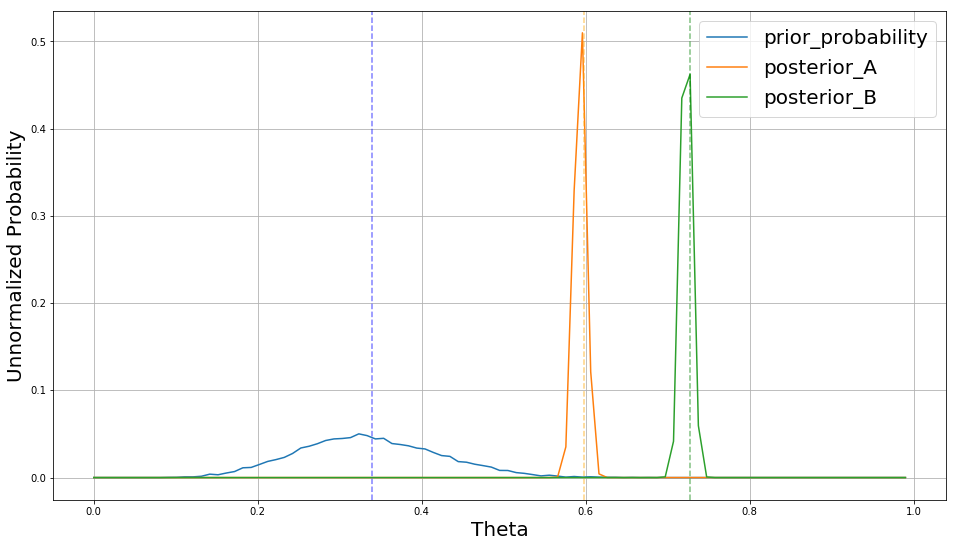

In [11]:
# plot prior vs posterior
fitprior_count, _ = np.histogram(beta(prior_a, prior_b).rvs(10000), bins)
fitprior_count = map(lambda x: float(x)/fitprior_count.sum(), fitprior_count)
posteriora_counts, _ = np.histogram(trace_a['prior'], bins)
posteriora_counts = map(lambda x: float(x)/posteriora_counts.sum(), posteriora_counts)
posteriorb_counts, _ = np.histogram(trace_b['prior'], bins)
posteriorb_counts = map(lambda x: float(x)/posteriorb_counts.sum(), posteriorb_counts)

mean_prior = np.mean(beta(prior_a, prior_b).rvs(10000))
mean_a = np.mean(trace_a['prior'])
mean_b = np.mean(trace_b['prior'])
                     
plt.plot(bins[:-1], fitprior_count, label='prior_probability')
plt.axvline(mean_prior, color='b', linestyle="--", alpha=0.5)
plt.plot(bins[:-1], posteriora_counts, label='posterior_A')
plt.axvline(mean_a, color='orange', linestyle="--", alpha=0.5)
plt.plot(bins[:-1], posteriorb_counts, label='posterior_B')
plt.axvline(mean_b, color='g', linestyle="--", alpha=0.5)
plt.grid()
plt.legend(loc='upper right', prop={'size': 20})
plt.xlabel('Theta', fontsize=20)
plt.ylabel('Unnormalized Probability', fontsize=20)
plt.show()

In [12]:
print('the most plausible probability: \nprior_raw {:2.2%}, \nposterior_a: {:2.2%}, \nposterior_b: {:2.2%}'\
      .format(mean_prior, mean_a, mean_b))

the most plausible probability: 
prior_raw 33.92%, 
posterior_a: 59.83%, 
posterior_b: 72.77%


Now, by increasing the testing sample to 5000, our prior belief changed dramatically from 33.92% to 72.77% for the case of B. Notice the shape of these probability, the prior probability is more flatter than both of the posterior ones, which means we have less confidence using only the prior probability. The posterior_B is "shorter" than the posterior_A so which mean the prediction based on B will be less "confident" than that of A.

That raise a question of whether or not the posterior_b is actual greater than posterior_a ?

We can answer that question by constructing a different posterior probability function between posterior_A and posterior_B, namely diff:

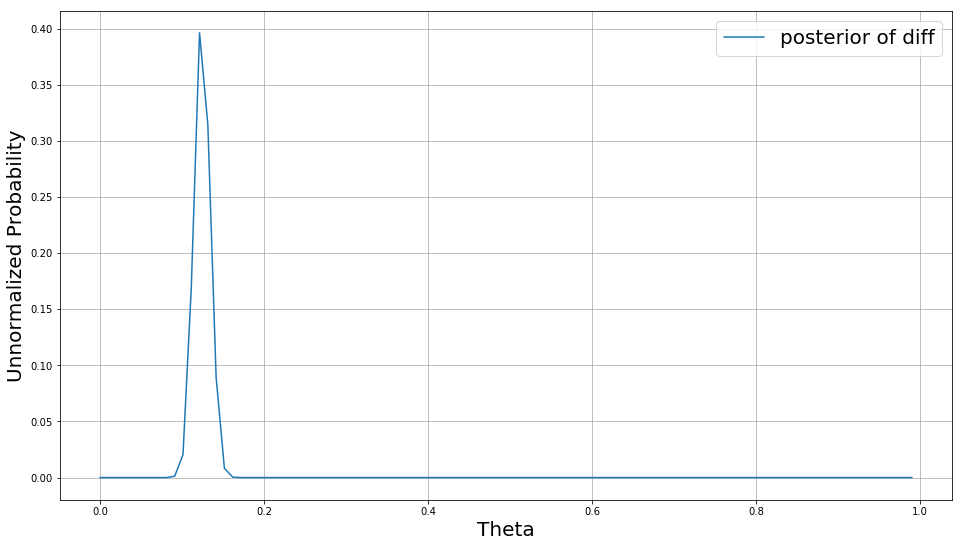

In [15]:
# case A: 𝑁 = 5000, 𝐶 = 0.6*5000 = 3000
# case B: 𝑁 = 5000, 𝐶 = 0.73*5000 = 3650
# Simply substrac posterior probability b to posterior probability a
trace_diff = trace_b['prior'] - trace_a['prior']
dif_counts, _ = np.histogram(trace_diff, bins)
dif_counts = map(lambda x: float(x)/dif_counts.sum(), dif_counts)
mean_dif = np.mean(trace_diff)

plt.plot(bins[:-1], dif_counts, label='posterior of diff')
plt.grid()
plt.legend(loc='upper right', prop={'size': 20})
plt.xlabel('Theta', fontsize=20)
plt.ylabel('Unnormalized Probability', fontsize=20)
plt.show()

In [16]:
# P(diff > 0)
np.mean(trace_diff>0)

1.0

As we can see the probability that posterior_B is greather posterior_A is $P(diff > 0) \approx 1$ in this case.

Lets try another case when N_a differs from N_b

In [17]:
# case A: 𝑁 = 5000, 𝐶 = 0.6*5000 = 3000
with pm.Model() as model:
    theta_prior = pm.Beta('prior', prior_a, prior_b) # prior distribution
    observations = pm.Binomial('obs', n=5000, p=theta_prior, observed=3000) # likelihood distribution 
    trace_a = pm.sample(5000, tuning=500, cores=1, progressbar=True, nuts_kwargs=dict(target_accept=0.95))
    
# case B: 𝑁 = 200, 𝐶 = 0.73*200 = 146
with pm.Model() as model:
    theta_prior = pm.Beta('prior', prior_a, prior_b) # prior distribution
    observations = pm.Binomial('obs', n=200, p=theta_prior, observed=146) # likelihood distribution 
    trace_b = pm.sample(5000, tuning=500, cores=1, progressbar=True, nuts_kwargs=dict(target_accept=0.95)) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [prior]
100%|████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:05<00:00, 1098.02it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [prior]
100%|████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:04<00:00, 1222.77it/s]


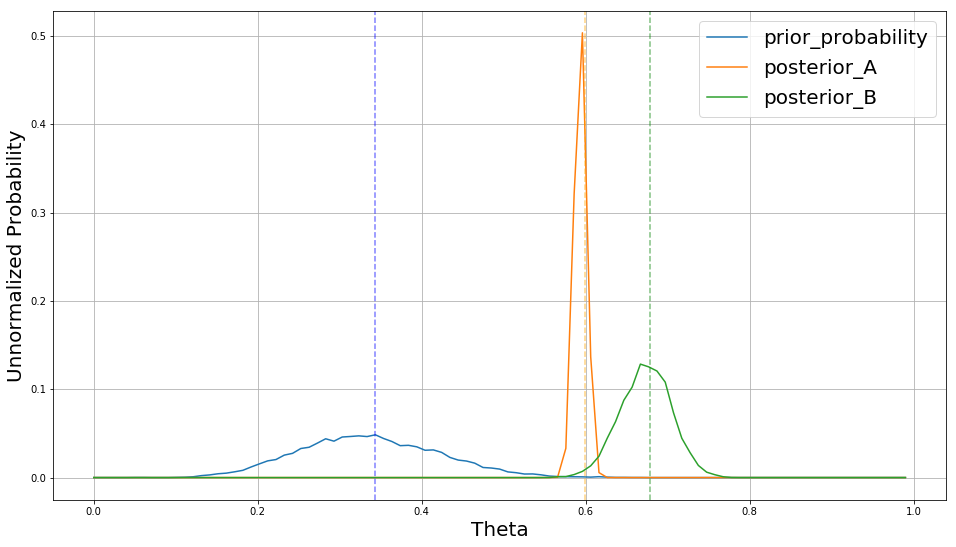

In [18]:
# plot prior vs posterior
fitprior_count, _ = np.histogram(beta(prior_a, prior_b).rvs(10000), bins)
fitprior_count = map(lambda x: float(x)/fitprior_count.sum(), fitprior_count)
posteriora_counts, _ = np.histogram(trace_a['prior'], bins)
posteriora_counts = map(lambda x: float(x)/posteriora_counts.sum(), posteriora_counts)
posteriorb_counts, _ = np.histogram(trace_b['prior'], bins)
posteriorb_counts = map(lambda x: float(x)/posteriorb_counts.sum(), posteriorb_counts)

mean_prior = np.mean(beta(prior_a, prior_b).rvs(10000))
mean_a = np.mean(trace_a['prior'])
mean_b = np.mean(trace_b['prior'])
                     
plt.plot(bins[:-1], fitprior_count, label='prior_probability')
plt.axvline(mean_prior, color='b', linestyle="--", alpha=0.5)
plt.plot(bins[:-1], posteriora_counts, label='posterior_A')
plt.axvline(mean_a, color='orange', linestyle="--", alpha=0.5)
plt.plot(bins[:-1], posteriorb_counts, label='posterior_B')
plt.axvline(mean_b, color='g', linestyle="--", alpha=0.5)
plt.grid()
plt.legend(loc='upper right', prop={'size': 20})
plt.xlabel('Theta', fontsize=20)
plt.ylabel('Unnormalized Probability', fontsize=20)
plt.show()  

In [19]:
print('the most plausible probability: \nprior_raw {:2.2%}, \nposterior_a: {:2.2%}, \nposterior_b: {:2.2%}'\
      .format(mean_prior, mean_a, mean_b))

the most plausible probability: 
prior_raw 34.25%, 
posterior_a: 59.86%, 
posterior_b: 67.80%


It can be seen the posterior B become flatter which means the decision based on B now become a little bit suspicious, lets see what is the probabilty that posterior B is actualy greater than the posterior A.

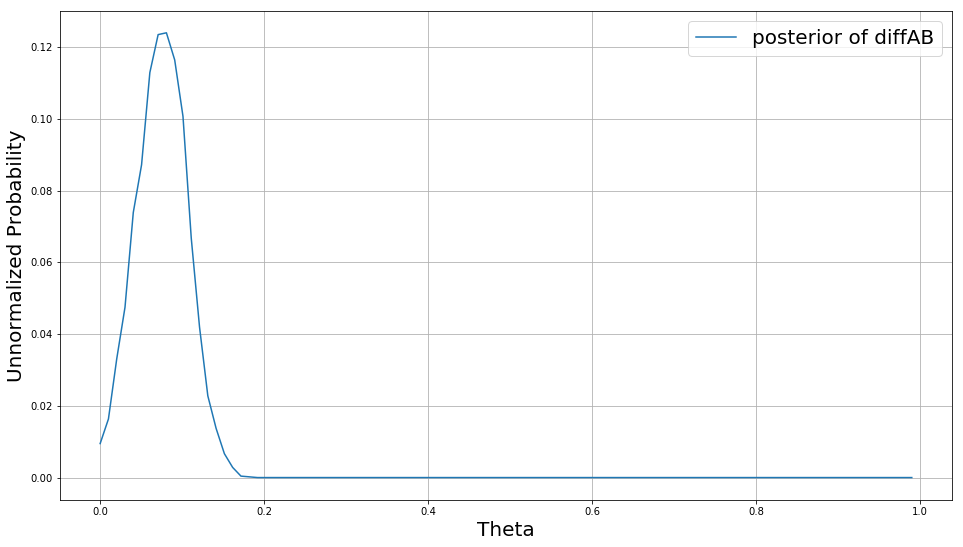

In [22]:
# case A: 𝑁 = 5000, 𝐶 = 0.6*5000 = 3000
# case B: 𝑁 = 200, 𝐶 = 0.73*5000 = 146
# Simply substract posterior probability b to posterior probability a
trace_diff = trace_b['prior'] - trace_a['prior']
dif_counts, _ = np.histogram(trace_diff, bins)
dif_counts = map(lambda x: float(x)/dif_counts.sum(), dif_counts)
mean_dif = np.mean(trace_diff)

plt.plot(bins[:-1], dif_counts, label='posterior of diffAB')
plt.grid()
plt.legend(loc='upper right', prop={'size': 20})
plt.xlabel('Theta', fontsize=20)
plt.ylabel('Unnormalized Probability', fontsize=20)
plt.show()

In [23]:
# P(diff > 0)
np.mean(trace_diff>0)

0.9922

The confidence has a slightly effect, however still really high 99.22% which means the design B is the right way to go for this marketing campaign.

# Interpreter
- We should follow the design B which is to change the  buy-button on the shopping website to Blue. As the proabability that the next customer will click onto the blue buy-button is higher than that of red buy-button.